In [2]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation


This is an example of applying :class:`sklearn.decomposition.NMF` and
:class:`sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a list of topics, each represented as a list of
terms (weights are not shown).

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).




In [11]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function

import itertools
from pathlib import Path
from time import time
import os

from text_processing.simple import parse_all

n_samples = 20000
n_topics = 400


print("Loading dataset...")
t0 = time()
data_samples = list(itertools.islice(parse_all("./out/docs_simple2", from_cache=True), n_samples))
print("loaded %d samples in %0.3fs." % (len(data_samples), time() - t0))

Loading dataset...
loaded 20000 samples in 5.629s.


In [12]:
from collections import defaultdict

from nltk.stem.snowball import SnowballStemmer

import numpy as np


class key_dependent_dict(defaultdict):
    def __init__(self, f_of_x):
        super().__init__(None) # base class doesn't get a factory
        self.f_of_x = f_of_x # save f(x)
    def __missing__(self, key): # called when a default needed
        ret = self.f_of_x(key) # calculate default value
        self[key] = ret # and install it in the dict
        return ret


STOP_WORDS = {'от', 'на', 'не', 'рф', 'ст'}

stemmer = SnowballStemmer("russian")
CACHE = key_dependent_dict(lambda w: stemmer.stem(w))

In [13]:
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer

analyzer = TfidfVectorizer().build_analyzer()
texts = [[CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS] for doc in data_samples]
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=10, no_above=0.66)
print(len(dictionary))

12294


In [14]:
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus, smartirs='ntc')
corpus_tfidf = tfidf[corpus]

In [15]:
t0 = time()
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_topics*2)
index = similarities.MatrixSimilarity(lsi[corpus_tfidf]) # transform corpus to LSI space and index it
print("LSI index built in %.3fs" % (time()-t0))

LSI index built in 178.079s


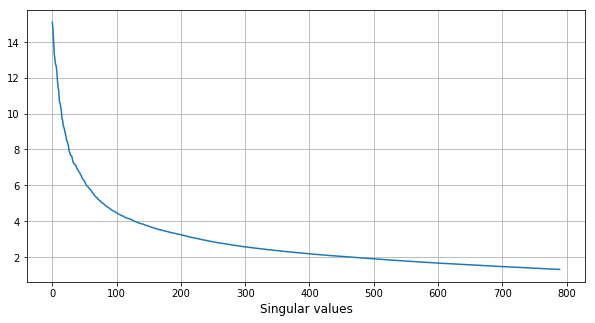

In [19]:
s = lsi.projection.s

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(s[10:])
#plt.plot(np.cumsum(s[:]), c='green')
plt.xlabel('Singular values', fontsize=12)
plt.grid(True, 'both')
plt.show()

In [17]:
lsi.print_topics(20,30)

[(0,
  '0.277*"неустойк" + 0.249*"услуг" + 0.194*"энерг" + 0.180*"товар" + 0.160*"работ" + 0.132*"год" + 0.127*"средств" + 0.126*"пен" + 0.109*"ден" + 0.108*"организац" + 0.108*"поставк" + 0.107*"фактическ" + 0.107*"просрочк" + 0.106*"заказчик" + 0.094*"кредитор" + 0.094*"имуществ" + 0.088*"покупател" + 0.088*"счет" + 0.087*"процент" + 0.086*"выполнен" + 0.084*"обяз" + 0.080*"долг" + 0.080*"стоимост" + 0.079*"плат" + 0.079*"датег" + 0.078*"должник" + 0.077*"федеральн" + 0.077*"документ" + 0.075*"решен" + 0.071*"электрическ"'),
 (1,
  '0.546*"энерг" + -0.326*"работ" + -0.220*"товар" + 0.197*"электрическ" + 0.174*"теплов" + 0.173*"потреблен" + -0.169*"выполнен" + 0.158*"организац" + -0.154*"заказчик" + 0.139*"потребител" + 0.131*"фактическ" + 0.130*"абонент" + 0.102*"ден" + 0.099*"коммунальн" + 0.099*"сет" + -0.098*"подрядчик" + -0.092*"средств" + 0.083*"прибор" + 0.082*"энергоснабжен" + -0.082*"контракт" + 0.081*"мощност" + -0.078*"покупател" + 0.077*"месяц" + 0.076*"вод" + -0.073*"проц

In [20]:
idx = 1657
print(data_samples[idx])
doc = corpus_tfidf[idx]
vec_lsi = lsi[doc] # convert the vector to LSI space
sims = index[vec_lsi] # perform a similarity vector against the corpus
most_similar = np.argsort(-sims)[1:]
print()
print(most_similar[0])
print()
print(data_samples[most_similar[0]])

Истец обратился в Арбитражный суд Волгоградской области к  ответчику  с исковым заявлением,   в котором просит   взыскать задолженность    в сумме SUM, проценты за пользование коммерческим кредитом в сумме SUM, расходы по оплате госпошлины в сумме SUM

Истец просил удовлетворить исковые требования в полном объеме.

Ответчик   в судебное заседание не явился, извещен надлежащим образом,  письменного отзыва не представил.

В силу ст.156 АПК РФ дело рассмотрено в отсутствие ответчика, извещенного надлежащим образом о месте и времени судебного заседания.

Суд, изучив материалы дела,   выслушав истца, оценив фактические обстоятельства, находит заявленные исковые требования обоснованными и подлежащими удовлетворению       по следующим основаниям.

Из материалов дела следует,  что 16 марта 2015 года между ORG с одной стороны и ИП Главой К(Ф)Х Кажгалиевым С.В. с другой стороны был заключен договор продажи № Н15СЗР-042, согласно условиям которого ORG обязуется предать в собственность ИП Главы К(

In [18]:
tf = sorted(corpus_tfidf[idx], key=lambda x:x[1], reverse=True)[:50]
print(list(map(lambda t: (dictionary[t[0]], t[1]), tf)))

print()

tf_m = sorted(corpus_tfidf[most_similar[0]], key=lambda x:x[1], reverse=True)[:50]
print(list(map(lambda t: (dictionary[t[0]], t[1]), tf_m)))

[('год', 0.5890941889632927), ('товар', 0.3720594877662901), ('2015', 0.3100495731385751), ('2016', 0.2480396585108601), ('продаж', 0.18602974388314505), ('04', 0.1705272652262163), ('последн', 0.1705272652262163), ('16', 0.15502478656928756), ('19', 0.10851735059850129), ('спецификац', 0.10851735059850129), ('глав', 0.10851735059850129), ('обяз', 0.10851735059850129), ('23', 0.09301487194157253), ('поставлен', 0.09301487194157253), ('06', 0.07751239328464378), ('коммерческ', 0.07751239328464378), ('осуществля', 0.07751239328464378), ('покупател', 0.07751239328464378), ('111', 0.07751239328464378), ('ип', 0.07751239328464378), ('кредит', 0.07751239328464378), ('042', 0.07751239328464378), ('074', 0.07751239328464378), ('пользован', 0.062009914627715025), ('товарн', 0.062009914627715025), ('05', 0.062009914627715025), ('процент', 0.062009914627715025), ('переда', 0.062009914627715025), ('сельскохозяйствен', 0.062009914627715025), ('сем', 0.062009914627715025), ('культур', 0.062009914627

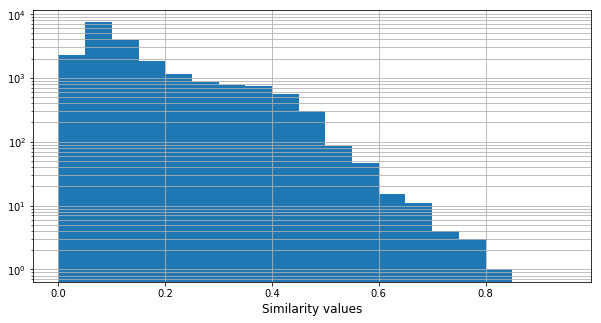

In [25]:
plt.figure(figsize=(10,5))
plt.hist(sims, bins=np.arange(0.0, 1.0, 0.05), log=True)
plt.xlabel('Similarity values', fontsize=12)
plt.grid(True, 'both')
plt.show()